<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Planetary Motion - Three Body Problem

### Examples - Astrophysics
<section class="post-meta">
By Jonas Tjemsland, Andreas Krogen, Håkon Ånes and Jon Andreas Støvneng
</section>
Last edited: March 22nd 2018 
___

This example is a continuation of [Planetary Motion](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/planetary_motion.ipynb), which discussed different constant step size ordinary differential equation (ODE) solvers (such as Forward Euler, Explicit Trapezoid, Midpoint Rule and fourth order Runge-Kutta) applied on a two dimensional one body problem. In this example we will use an adaptive step size ODE solver (Embedded Runge-Kutta pair) to solve two and three body problems. A brief motivation for the adaptive step size is explained in [Adaptive Runge-Kutta Methods](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/adaptive_runge_kutta_methods.ipynb).

![CMoore orbit](CMoore1993.gif) <center>Figure-8 orbit discovered by C. Moore in 1993 [1].</center>


First we import the necessary libraries and set some common figure parameters.

In [1]:
# Import libraries
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (14, 7), 'axes.grid': False,
             'lines.markersize': 6, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

### Equations of motion

The gravitational pull between two objects is under classical conditions given by Newton's law of gravitation,

$$
\vec{F}_{21}(t)=\vec{F}_{12}(t) = -\frac{Gm_1m_2}{{\vec{r_{12}}(t)}^3}\vec r_{12},
$$

where $m_1$ and $m_2$ are the masses of the two objects, $r$ is the distance between them and $G\approx 6.67\times 10^{-11} \,\text{m}^3/ \text{kg}\,\text{s}^2$ is the gravitational constant. Newton's  law holds if it is assumed that the masses of the objects are isotropically distributed.

Consider a three body problem with three objects given by masses $m_1$, $m_2$ and $m_3$. By the principle of superposition, the gravitational pull on an object will be the sum of the gravitational pull of all the other objects $F_1 = F_{12} + F_{13}$. Thus, the equations of motion (EoM) of say $m_1$ is given by

$$
\ddot{\vec{r}}_1(t) = -\frac{Gm_2}{\left[\vec{r}_{2}(t)-\vec{r}_{1}(t)\right]^3}\left[\vec{r}_{2}(t)-\vec{r}_{1}(t)\right]-\frac{Gm_3}{\left[\vec{r}_{3}(t)-\vec{r}_{1}(t)\right]^3}\left[\vec{r}_{3}(t)-\vec{r}_{1}(t)\right],
$$

$$
\dot{\vec{r}}_1(t)=\vec{v}_1.
$$

The EoM in this problem is a set of ODEs. By giving two initial conditions, e.g. the starting velocity and position, we can reduce the problem to two ODEs, where the next step of the first ODE depends on the previous step of the second ODE. The right hand side (RHS) of the EoM can be described by the following function:

In [2]:
def RHS(t, y):
    """Calculate the RHS of the EoM, as described above.
    Parameters:
        y: array. Vector of length 12 holding the current position and velocity of the three objects 
           in the following manner: y = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        z: array. Vector of length 12 holding the derivative of the current position and velocity 
           (the velocity and acceleration) of the three object in the following manner:
           z = [vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3].
    """
    
    # Allocate a vector to hold the output values
    z = np.zeros(12)
    # Define initial velocities and distances between objects
    z[:6] = [y[6], y[7], y[8], y[9], y[10], y[11]]
    r21 = ((y[2] - y[0])**2.0 + (y[3] - y[1])**2.0)**0.5
    r31 = ((y[4] - y[0])**2.0 + (y[5] - y[1])**2.0)**0.5
    r32 = ((y[4] - y[2])**2.0 + (y[5] - y[3])**2.0)**0.5
    # Pairwise forces
    Fx21 = G*m2*m1*(y[2] - y[0])/r21**3.0
    Fy21 = G*m2*m1*(y[3] - y[1])/r21**3.0
    Fx31 = G*m3*m1*(y[4] - y[0])/r31**3.0
    Fy31 = G*m3*m1*(y[5] - y[1])/r31**3.0
    Fx32 = G*m3*m2*(y[4] - y[2])/r32**3.0
    Fy32 = G*m3*m2*(y[5] - y[3])/r32**3.0
    # Accelerations
    z[6] = (Fx21 + Fx31)/m1
    z[7] = (Fy21 + Fy31)/m1
    z[8] = (-Fx21 + Fx32)/m2
    z[9] = (-Fy21 + Fy32)/m2
    z[10] = (-Fx31 - Fx32)/m3
    z[11] = (-Fy31 - Fy32)/m3
    
    return z

### Conservation of energy and angular momentum

Since there are no forces or torques acting on the system (and no form of loss within the system), both the energy and the angular momentum stays constant. This provides a way to check if our calculations are sufficiently accurate. The kinetic energy, $K$, is given by

$$
K=\frac{1}{2}m\vec v^2,
$$

where $m$ is the mass and $v$ is the velocity. The potential energy $U$ between two objects is given by

$$
U=-\frac{Gm_1m_2}{r_{12}},
$$

where $G$ is the gravitational constant, $m_i$ is the mass of object $i$ and $r$ is the distance between the two objects. The energies of the system can thus be calculated by:

In [3]:
def energy(z):
    """Calculate the mechanical energies of the three body system.
    Parameters:
        z: array. Vector of length 12 holding the current position and velocity of the three objects in the
           following manner: z = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        U: float. The potential energies of the system.
        K: float. The kinetic energies of the system.
    """
    
    # Pairwise distance between objects
    r21 = ((z[2] - z[0])**2.0 + (z[3] - z[1])**2.0)**0.5
    r31 = ((z[4] - z[0])**2.0 + (z[5] - z[1])**2.0)**0.5
    r32 = ((z[4] - z[2])**2.0 + (z[5] - z[3])**2.0)**0.5
    
    # Calculate potential energies
    # First object is "free", second object is moved from infinity to a distance r21 from the first object.
    # Third object is affected gravitationally by both objects.
    U1 = 0
    U2 = -G*m1*m2/r21
    U3 = -G*m1*m3/r31 - G*m3*m2/r32
    U = U1 + U2 + U3
    
    # Calculate kinetic energies of the three objects
    K1 = 0.5*m1*(z[6]**2 + z[7]**2)
    K2 = 0.5*m2*(z[8]**2 + z[9]**2)
    K3 = 0.5*m3*(z[10]**2 + z[11]**2)
    K = K1 + K2 + K3
    
    return U, K

Furthermore, in this setup the absolute angular momentum $\vec L = \vec R\times m\vec v$ stays constant, and can be calculated by:

In [4]:
def angularMomentum(y):
    """Calculate absolute angular momentum of the three body system.
    Parameters:
        y:          array. Vector of length 12 holding the current position and velocity of the three objects
                    in the following manner: y = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        L1, L2, L3: array. Total absolute angular momentum of the system.
    """
    
    L1 = m1*(y[0]*y[7] - y[1]*y[6])
    L2 = m2*(y[2]*y[9] - y[3]*y[8])
    L3 = m3*(y[4]*y[11] - y[5]*y[10])
    
    return [L1, L2, L3]

### Embedded Runge-Kutta pair

We now implement the embedded Runge-Kutta pair (often called an adaptive Runge-Kutta method) to solve the EoM. In short, it is a scheme that uses two different Runge-Kutta methods of different order to get an estimate of the local truncation error. Thus, it is possible to more or less decide what accuracy we want the solution to have by adjusting the step size for each iteration. Another advantage of the adaptive step size method is that we achieve better accuracy where it is needed and lower accuracy where it is not (an example will follow). However, these methods may become more computationally demanding, and hence won't improve our implementation in every case.

The implementation can also be done with a constant step size method, which is done in the animation section below.

We are going to use the Runge-Kutta-Fehlberg order 4 / order 5 embedded pair (RKF45) as described in [Adaptive Runge-Kutta Methods](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/adaptive_runge_kutta_methods.ipynb):

In [5]:
def ode45(f,t,y,h):
    """Calculate next step of an initial value problem (IVP) of an ODE with a RHS described
    by the RHS function with an order 4 approx. and an order 5 approx.
    Parameters:
        t: float. Current time.
        y: float. Current step (position).
        h: float. Step-length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    
    s1 = f(t, y)
    s2 = f(t + h/4.0, y + h*s1/4.0)
    s3 = f(t + 3.0*h/8.0, y + 3.0*h*s1/32.0 + 9.0*h*s2/32.0)
    s4 = f(t + 12.0*h/13.0, y + 1932.0*h*s1/2197.0 - 7200.0*h*s2/2197.0 + 7296.0*h*s3/2197.0)
    s5 = f(t + h, y + 439.0*h*s1/216.0 - 8.0*h*s2 + 3680.0*h*s3/513.0 - 845.0*h*s4/4104.0)
    s6 = f(t + h/2.0, y - 8.0*h*s1/27.0 + 2*h*s2 - 3544.0*h*s3/2565 + 1859.0*h*s4/4104.0 - 11.0*h*s5/40.0)
    w = y + h*(25.0*s1/216.0 + 1408.0*s3/2565.0 + 2197.0*s4/4104.0 - s5/5.0)
    q = y + h*(16.0*s1/135.0 + 6656.0*s3/12825.0 + 28561.0*s4/56430.0 - 9.0*s5/50.0 + 2.0*s6/55.0)
    
    return w, q

To get some basis for comparison we will also use the Ordinary (fourth order) Runge-Kutta method, as described in [Runge Kutta Method](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/runge_kutta_method.ipynb) (this method will be used to make animations):

In [6]:
def rk4step(f, t, y, h):
    """Calculate next step of an IVP of an ODE with a RHS described by the RHS function with RK4.
    Parameters:
        f: function. Right hand side of the ODE.
        t: float. Current time.
        y: float. Current step (position).
        h: float. Step-length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    
    s1 = f(t, y)
    s2 = f(t + h/2.0, y + h*s1/2.0)
    s3 = f(t + h/2.0, y + h*s2/2.0)
    s4 = f(t + h, y + h*s3)
    
    return y + h/6.0*(s1 + 2.0*s2 + 2.0*s3 + s4)

### Computations

Time to put it all together and plot the results. Initially, this solution describes a three body problem, but by choosing one of the masses equal to zero, the system will behave as if it is a two body system.

To start with, we will choose initial conditions and set global constants:

In [7]:
# Set gravitaional constant and masses.
# The gravitaional constant is set to 1 for simplicity.
G = 1.
m1 = 1.
m2 = 1.
m3 = 1.

# Period of calculations
T = 5
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 1000
# "Protector-constant" for small w
theta = 0.001
# Number of steps (RK4)
n = 1000

# Different initial conditions to try out, on the form
# y = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]
# z0 = [2., 2., 0., 0., -2., -2., 0.2, -0.2, 0., 0., -0.2, 0.2]
# z0 = [-0.970, 0.243, 0.970, -0.243, 0., 0., -0.466, -0.433, -0.466, -0.433, 2*0.466, 2*0.433]
# z0 = [2., 0., -2., 0., 0., 0., 0., -0.6, -0.6, 0., 0., 0.]
z0 = [1., 0.000001, -1., 0., 0., 0., 0., -0.4, 0., 0.4, 0., 0.]

We are now ready to perform the calculations and plot the results. To get a feel for the problem, you should run the notebook yourself and try out different initial conditions $z_0$. E.g., for the last $z_{0}$ listed above, if you set $y_{2} = 0$ instead of, say, $0.000001$, the orbits are stable. As we will see below, the three body system is highly sensitive to the initial conditions.

In [8]:
# First step and initial time
h = T/n
t = 0.

# Allocate matrices and fill with initial conditions
Z = np.zeros((12, maxi + 1))
Z[:, 0] = z0
E = np.zeros((maxi + 1, 2))
E[0, :] = energy(z0)
L = np.zeros((maxi + 1, 3))
L[0, :] = angularMomentum(z0)

# Declare iteration integer
i = 0
e=1.
# Perform ode45 calculations
tic = time.time()
while (t < T) & (i < maxi):
    w, q = ode45(RHS, t, Z[:, i], h)
    e = max(abs((w - q)/np.maximum(w, theta)))
    if e > TOL:
        h = 0.95*(TOL*e)**(1/5)*h 
        w, q = ode45(RHS, t, q, h)
        e = max(abs((w - q)/np.maximum(w, theta)))
        while e > TOL:
            h = h/2.
            w, q = ode45(RHS, t, q, h)
            e = max(abs((w - q)/maximum(w, theta)))
    if e < 0.1*TOL:
        h = h*2.
    Z[:, i+1] = q
    E[i+1, :] = energy(Z[:, i+1])
    L[i+1, :] = angularMomentum(Z[:, i+1])
    t += h
    i += 1

print("%.5f s, run time of adaptive RK45 method." % (time.time() - tic))
    
# Print number of steps used
if (i == maxi):
    print('%i, maximum number of steps reached by adaptive RK45 method.' % i)
else:
    print('%i, steps used by adaptive RK45 method.' % i)

0.61311 s, run time of adaptive RK45 method.
999, steps used by adaptive RK45 method.


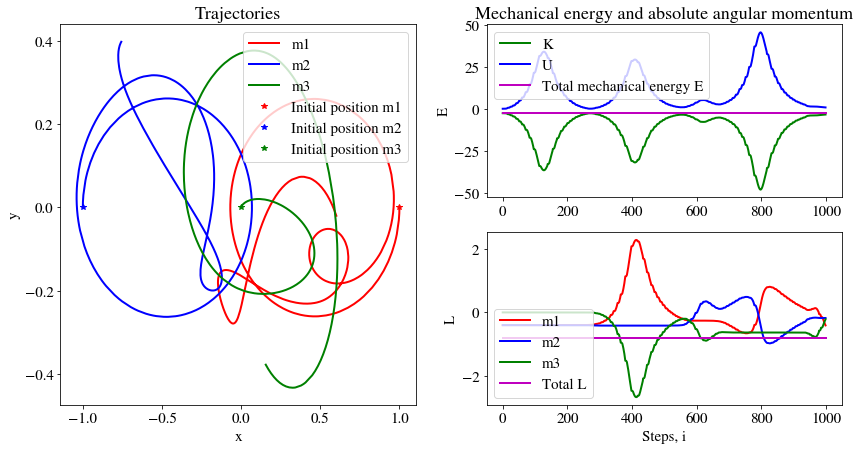

In [9]:
# Plot result
plt.figure()

# Position
plt.subplot(2, 2, (1, 3))
plt.plot(Z[0, 0:i], Z[1, 0:i], '-r', label='m1')
plt.plot(Z[2, 0:i], Z[3, 0:i], '-b', label='m2')
plt.plot(Z[4, 0:i], Z[5, 0:i], '-g', label='m3')
plt.plot(Z[0, 0], Z[1, 0], '*r', label='Initial position m1')
plt.plot(Z[2, 0], Z[3, 0], '*b', label='Initial position m2')
plt.plot(Z[4, 0], Z[5, 0], '*g', label='Initial position m3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.title('Trajectories')

# Mechanical energy
plt.subplot(2, 2, 2)
plt.plot(E[0:i, 0], 'g', label='K')
plt.plot(E[0:i, 1], 'b', label='U')
plt.plot(E[0:i, 0] + E[0:i ,1], 'm', label='Total mechanical energy E')
plt.ylabel('E')
plt.legend(loc='best')
plt.title('Mechanical energy and absolute angular momentum')

# Angular momentum
plt.subplot(2, 2, 4)
plt.plot(L[0:i, 0], 'r', label='m1')
plt.plot(L[0:i, 1], 'b', label='m2')
plt.plot(L[0:i, 2], 'g', label='m3')
plt.plot(L[0:i, 0] + L[0:i, 1] + L[0:i, 2], 'm', label='Total L')
plt.xlabel('Steps, i')
plt.ylabel('L')
plt.legend(loc=3)
plt.show()

With the initial conditions $z_0$ chosen above the three body system is unstable, hence $m_2$ drifts off by itself while $m_1$ and $m_3$ engages in a tight dance together. Furthermore, the total angular momentum $L$ and the total mechanical energy $E$ are fairly constant throughout the calculation, indicating sufficiently accurate calculations.

This method often require few steps. As a consequence, the plot might seem somewhat poor, even though the accuracy might be high. Using the RK4 method without adapting the step size to the tolerance, we get a different picture.

In [11]:
# Set constant step size
h = T/n

# Set initial time
t = 0.

# Allocate matrices and fill with initial conditions
Z2 = np.zeros((12, n+1))
Z2[:, 0] = z0
E2 = np.zeros((n+1, 2))
E2[0, :] = energy(z0)
L2 = np.zeros((n+1, 3))
L2[0, :] = angularMomentum(z0)

tic = time.time()
for i in range(0, n):
    Z2[:, i+1] = rk4step(RHS, t, Z2[:, i], h)
    E2[i+1, :] = energy(Z2[:, i+1])
    L2[i+1, :] = angularMomentum(Z2[:, i+1])
    t += h


print("%.5f s, run time of RK4 method, with %i steps."% (time.time() - tic, n))

0.27486 s, run time of RK4 method, with 1000 steps.


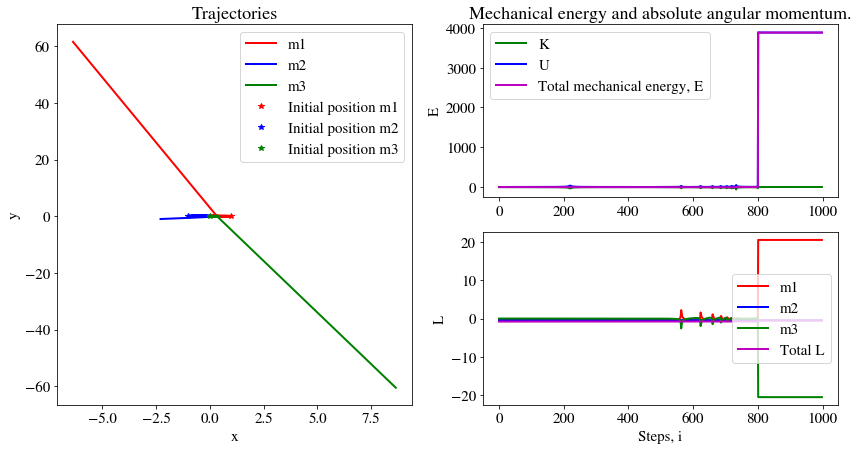

In [12]:
# Plot result
plt.figure()

# Position
plt.subplot(2, 2, (1, 3))
plt.plot(Z2[0, 0:i], Z2[1, 0:i], '-r', label='m1')
plt.plot(Z2[2, 0:i], Z2[3, 0:i], '-b', label='m2')
plt.plot(Z2[4, 0:i], Z2[5, 0:i], '-g', label='m3')
plt.plot(Z2[0, 0], Z2[1, 0], '*r', label='Initial position m1')
plt.plot(Z2[2, 0], Z2[3, 0], '*b', label='Initial position m2')
plt.plot(Z2[4, 0], Z2[5, 0], '*g', label='Initial position m3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.title('Trajectories')

# Mechanical energy
plt.subplot(2, 2, 2)
plt.plot(E2[0:i, 0], 'g', label='K')
plt.plot(E2[0:i, 1], 'b', label='U')
plt.plot(E2[0:i, 0] + E2[0:i, 1], 'm', label='Total mechanical energy, E')
plt.ylabel('E')
plt.legend(loc='best')
plt.title('Mechanical energy and absolute angular momentum.')

# Angular momentum
plt.subplot(2, 2, 4)
plt.plot(L2[0:i, 0], 'r', label='m1')
plt.plot(L2[0:i, 1], 'b', label='m2')
plt.plot(L2[0:i, 2], 'g', label='m3')
plt.plot(L2[0:i, 0] + L2[0:i, 1] + L2[0:i, 2], 'm', label='Total L')
plt.xlabel('Steps, i')
plt.ylabel('L')
plt.legend(loc='best')
plt.show()

It is obvious from taking a glance at the total mechanical energy $E$ and the total angular momentum $L$ that this calculation is flawed. We cannot trust the trajectories the ordinary fourth order Runge-Kutta (RK4) method produced with just a 1000 steps. In comparison, the adaptive Runge-Kutta (RK45) method performed better using only 224 steps, though it approximately doubled the execution time. Now, if we use an initial number of steps $n$ = 10 000, the ordinary RK4 method yields plausible trajectories (try for yourself). However, the adaptive RK45 method produce the same results in approximately the same number of steps as before, thus keeping its execution time low in comparison.

### Create an animation

The easiest way to create an animation is to use a constant step size function, such as the fourth order Runge-Kutta method (the last run computation will be animated). We are now going to animate the previous computations with $n$ = 10 000. The animation in the introduction was made with the following code:

In [ ]:
# Set up the figure
fig = plt.figure()
ax = plt.axes(xlim=(np.min(Z2[[0,2,4],:]), np.max(Z2[[0,2,4],:])), 
              ylim=(np.min(Z2[[1,3,5],:]), np.max(Z2[[1,3,5],:])))
ax.set_aspect('equal')

# Define the different elements in the animation
tail1, = ax.plot([],[],'r') # Tail obj. 1
tail2, = ax.plot([],[],'b') # Tail obj. 2
tail3, = ax.plot([],[],'g') # Tail obj. 3
obj1, = ax.plot([],[],'ro') # Obj. 1
obj2, = ax.plot([],[],'bo') # Obj. 2
obj3, = ax.plot([],[],'go') # Obj. 3

# Calculates the number of frames
FPS = 15
framesNum = int(FPS*T)

# Animation function. This is called sequentially.
def animate(j):
    i = j*int(n/framesNum)
    obj1.set_data(Z2[0,i],Z2[1,i])
    obj2.set_data(Z2[2,i],Z2[3,i])
    obj3.set_data(Z2[4,i],Z2[5,i])
    tail1.set_data(Z2[0,0:i],Z2[1,0:i])
    tail2.set_data(Z2[2,0:i],Z2[3,0:i])
    tail3.set_data(Z2[4,0:i],Z2[5,0:i])

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=framesNum)

# Save animation
# If this don't work for you, try using the another writer (ffmpeg, mencoder, imagemagick),
# or another file extension (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you have
# the codec and the writer installed on your system.
anim.save('ThreeBodyProblem.gif', writer='imagemagick', fps=FPS)

# Close plot
plt.close(anim._fig)

# Display the animation
with open('ThreeBodyProblem.gif','rb') as file:
    display(Image(file.read()))

### References and further reading

[1] Sauer, T.: *Numerical Analysis international edition*, 2nd edition, Pearson 2014

[2] *Runge-Kutta methods*, Wikipedia, https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods (Acquired: 13.03.16)

[3] Montgomery, R.: *A New Solution to the Three-Body Problem*, http://www.ams.org/notices/200105/fea-montgomery.pdf, 2001

---

### Exercises

1) Try to use the initial conditions z0 = [2.0,2.0,0.0,0.0,-2.0,-2.0,0.2,-0.2,0.0,0.0,-0.2,0.2]. Is this sytem stable? What happens if you change one of the initial parameters a small amount (e.g. x_3 = 0.0001)? Can you explain what happens?

2) Solve a two body problem by changing the codes.

3) Create some examples that validates Kepler's laws.